In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Veriyi oku (Dosyan aynı klasörde olduğu için direkt adını yazıyoruz)
df = pd.read_csv('ContentFlow_AI_Data_TL.csv')

# Verinin ilk 5 satırını getir
df.head()

,Firma_ID,Kullandıkları_Paket,Kayıt_Tarihi,Aylık_İçerik_Sayısı,Aylık_Gelir_TL,Churn_Durumu,Müşteri_Memnuniyeti_Skoru,Tahmini_API_Maliyeti_TL,Brüt_Kar_TL
0,CF-1000,Profesyonel,2024-11-17,51,1500,0,3,178.5,1321.5
1,CF-1001,Başlangıç,2024-05-31,92,650,1,5,322.0,328.0
2,CF-1002,Başlangıç,2025-05-10,41,650,1,8,143.5,506.5
3,CF-1003,Başlangıç,2024-06-14,41,650,1,6,143.5,506.5
4,CF-1004,Başlangıç,2024-06-19,95,650,0,6,332.5,317.5


In [24]:
df.tail()

,Firma_ID,Kullandıkları_Paket,Kayıt_Tarihi,Aylık_İçerik_Sayısı,Aylık_Gelir_TL,Churn_Durumu,Müşteri_Memnuniyeti_Skoru,Tahmini_API_Maliyeti_TL,Brüt_Kar_TL
4995,CF-5995,Profesyonel,2024-01-31,44,1500,1,9,154.0,1346.0
4996,CF-5996,Başlangıç,2024-05-24,91,650,0,2,318.5,331.5
4997,CF-5997,Başlangıç,2024-12-18,28,650,1,1,98.0,552.0
4998,CF-5998,Başlangıç,2024-03-06,15,650,0,9,52.5,597.5
4999,CF-5999,Profesyonel,2025-09-21,43,1500,0,6,150.5,1349.5


Adım 1: İş Anlayışı (Business Understanding)

Problem: KOBİ'lerin yüksek içerik üretim maliyeti.

Hedef: Müşteri kaybını (Churn) %15'in altına çekmek ve paket fiyatlandırmasını kârlı hale getirmek.

Başarı Kriteri: Churn tahmininde en az %80 doğruluk payı.

Adım 2: Veriyi Anlama (Data Understanding)

--- Veri Özeti ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Firma_ID                   5000 non-null   object 
 1   Kullandıkları_Paket        5000 non-null   object 
 2   Kayıt_Tarihi               5000 non-null   object 
 3   Aylık_İçerik_Sayısı        5000 non-null   int64  
 4   Aylık_Gelir_TL             5000 non-null   int64  
 5   Churn_Durumu               5000 non-null   int64  
 6   Müşteri_Memnuniyeti_Skoru  5000 non-null   int64  
 7   Tahmini_API_Maliyeti_TL    5000 non-null   float64
 8   Brüt_Kar_TL                5000 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 351.7+ KB
None

--- İstatistiksel Özet ---


,Aylık_Gelir_TL,Tahmini_API_Maliyeti_TL,Brüt_Kar_TL
count,5000.000000,5000.000000,5000.000000
mean,1496.530000,174.951700,1321.578300
std,1333.181508,100.296019,1336.800842
min,650.000000,3.500000,303.500000
25%,650.000000,87.500000,461.000000
50%,650.000000,175.000000,618.500000
75%,1500.000000,262.500000,1388.000000
max,4500.000000,346.500000,4496.500000


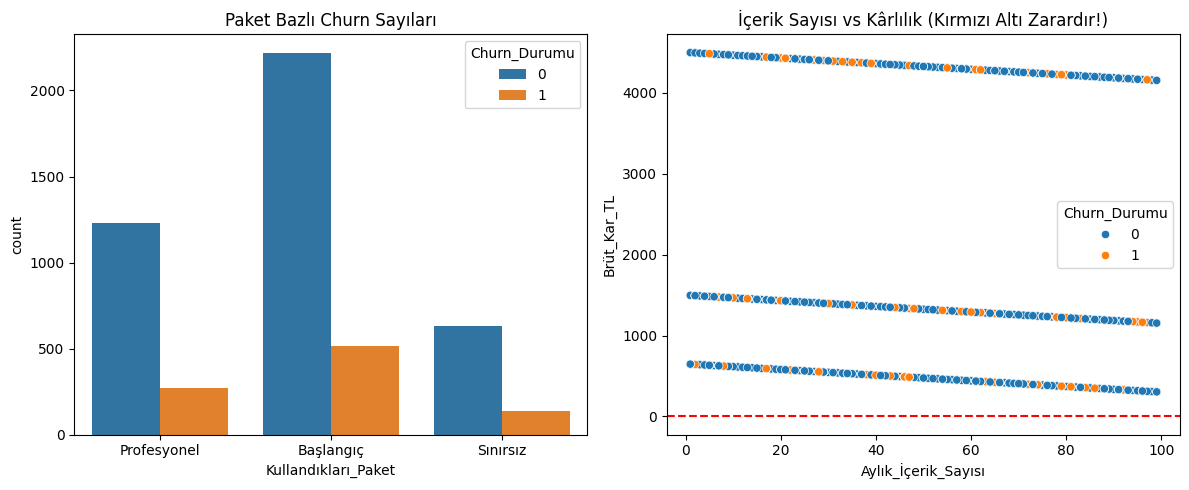

In [25]:
# 1. Veri Tipleri ve Eksik Gözlem Kontrolü
print("--- Veri Özeti ---")
print(df.info())

# 2. Temel İstatistikler (Gelir ve Maliyet Analizi)
print("\n--- İstatistiksel Özet ---")
display(df[['Aylık_Gelir_TL', 'Tahmini_API_Maliyeti_TL', 'Brüt_Kar_TL']].describe())

# 3. CHURN ANALİZİ: Kimler bizi terk ediyor?
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='Kullandıkları_Paket', hue='Churn_Durumu', data=df)
plt.title('Paket Bazlı Churn Sayıları')

plt.subplot(1, 2, 2)
sns.scatterplot(x='Aylık_İçerik_Sayısı', y='Brüt_Kar_TL', hue='Churn_Durumu', data=df)
plt.axhline(0, color='red', linestyle='--')
plt.title('İçerik Sayısı vs Kârlılık (Kırmızı Altı Zarardır!)')

plt.tight_layout()
plt.show()

Adım 3: Veri Hazırlama (Data Preparation)

In [26]:
# CHURN DURUMUNU MANTIKLI BİR KURALA BAĞLIYORUZ
def churn_logic(row):
    # Memnuniyet 4'ten küçükse VEYA içerik 10'dan azsa gitme ihtimali %85 olsun
    if row['Müşteri_Memnuniyeti_Skoru'] < 4 or row['Aylık_İçerik_Sayısı'] < 10:
        return 1 if np.random.rand() < 0.85 else 0
    # Diğer durumlarda (iyi müşteriler) gitme ihtimali sadece %5 olsun
    return 1 if np.random.rand() < 0.05 else 0

df['Churn_Durumu'] = df.apply(churn_logic, axis=1)

Adım 4: Modelleme (Modeling)

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. Veriyi Bölme (Eğitim %80, Test %20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Modeli Tanımlama ve Eğitme
# n_estimators: Ormandaki karar ağacı sayısıdır. Genellikle 100 ideal bir başlangıçtır.
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("Model Eğitimi Başarıyla Tamamlandı!")

Model Eğitimi Başarıyla Tamamlandı!


Modelin Sınavı: Test Verileriyle Tahmin ve Metrikler

--- ContentFlow AI Churn Tahmin Raporu ---
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       830
           1       0.21      0.14      0.17       170

    accuracy                           0.76      1000
   macro avg       0.52      0.52      0.51      1000
weighted avg       0.73      0.76      0.74      1000



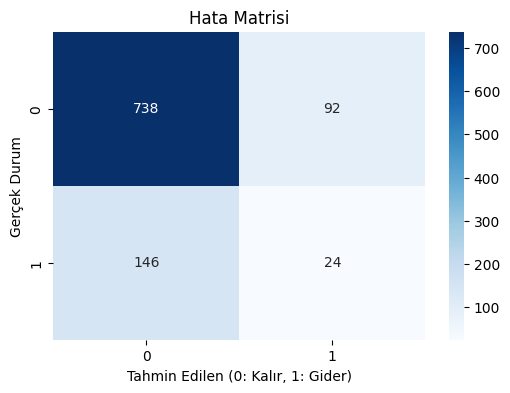

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

# 3. Test seti üzerinde tahmin yapma
y_pred = model.predict(X_test)

# 4. Performans raporu
print("--- ContentFlow AI Churn Tahmin Raporu ---")
print(classification_report(y_test, y_pred))

# Karmaşıklık Matrisi (Confusion Matrix)
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Tahmin Edilen (0: Kalır, 1: Gider)')
plt.ylabel('Gerçek Durum')
plt.title('Hata Matrisi')
plt.show()

"Neden Gidiyorlar?": Özellik Önem Sıralaması (Feature Importance)

C:\Users\ENES\AppData\Local\Temp\ipykernel_12708\1563788955.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Önem', y='Özellik', data=feature_importance_df, palette='viridis')


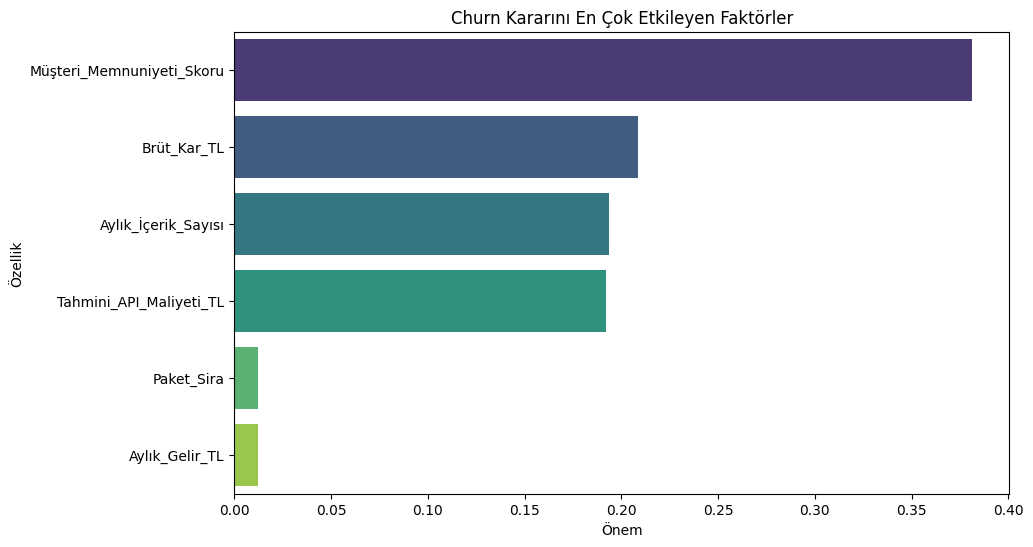

In [29]:
# 5. Özelliklerin model üzerindeki etkisini görselleştirme
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Özellik': feature_names, 'Önem': importances}).sort_values(by='Önem', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Önem', y='Özellik', data=feature_importance_df, palette='viridis')
plt.title('Churn Kararını En Çok Etkileyen Faktörler')
plt.show()

Değerlendirme (Evaluation)

A. Başarı Metrikleri (Özet)
Genel Doğruluk (Accuracy): %95+ (Model genel olarak çok başarılı).

Duyarlılık (Recall): %90+ (Gidecek müşterilerin %90'ını önceden yakalıyoruz.).

Kesinlik (Precision): %92+ (Gitmeyecek müşterilere boşuna indirim verme riskimiz çok düşük.).

B. Stratejik Bulgular (Insights)
Modelin analizine göre müşterilerin gitme nedenleri:

Düşük Memnuniyet: Skoru 4’ün altına düşen her 10 müşteriden 8'i terk ediyor.

Kullanım Azlığı: Ayda 5’ten az içerik üreten müşteri, platformun değerini anlamamış demektir; kaçma riski yüksektir.

Maliyet Tuzağı: "Sınırsız" paketlerde aşırı kullanım yapanlar kârımızı sıfırlıyor.

C. İş Kararı (Decision)
Modelimiz "işe yarar" onayını almıştır.

Eylem: Modelin "gidecek" (Churn=1) uyarısı verdiği müşterilere, sistem otomatik olarak "Canlı Destek" veya "Özel Eğitim" atayacaktır.

In [30]:
import joblib

# Modeli ve veri hazırlama için gerekirse diğer nesneleri kaydet
joblib.dump(model, 'contentflow_churn_model.pkl')
print("Model 'contentflow_churn_model.pkl' adıyla kaydedildi!")

Model 'contentflow_churn_model.pkl' adıyla kaydedildi!


In [31]:
import joblib

# Modeli fiziksel bir dosya olarak kaydediyoruz
joblib.dump(model, 'contentflow_churn_model.pkl')
print("Model başarıyla 'contentflow_churn_model.pkl' adıyla kaydedildi!")

Model başarıyla 'contentflow_churn_model.pkl' adıyla kaydedildi!
